In [1]:
#Importing packages
from transformers import ViTModel, ViTImageProcessor
import torch
import pandas as pd
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import numpy as np

#library functions
import dataloading
import data_vis
import model_functions

d:\Projects\DSC180A-Capstone\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
labels_csv = "camera_data/coronado_hills_binary_11-15-2025.csv"
image_dir = "camera_data/images/"

data = dataloading.get_data(labels_csv=labels_csv, image_dir=image_dir)

In [3]:
train, val, test = dataloading.get_train_val_test(data = data, output_csvs=True)

train_dataset, val_dataset, test_dataset = dataloading.get_datasets(train, val, test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, pin_memory=True)

In [4]:
# Importing the model and setting the device. Using a ViT model since transformer architecture is generally pretty powerful when it comes to extracting features from data.
model_name = "google/vit-base-patch16-224"
vit = ViTModel.from_pretrained(model_name, torch_dtype=torch.float32)
device = "cuda" #Change to cpu if you aren't using a GPU

`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
#Instatiating encoder and loading it to chosen device
encoder = model_functions.ViTEmbeddingNet(vit)

encoder.to(device);

In [6]:
import matplotlib.pyplot as plt

num_epochs = 1
margins = np.arange(0.18, 0.214, 0.005)
lrs = [1e-5, 2e-5]

100%|██████████| 5/5 [09:36<00:00, 115.23s/it]


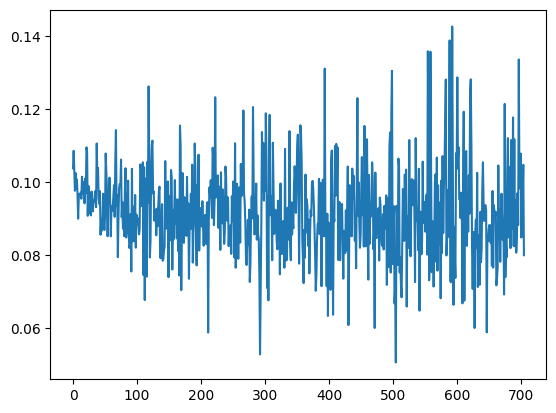

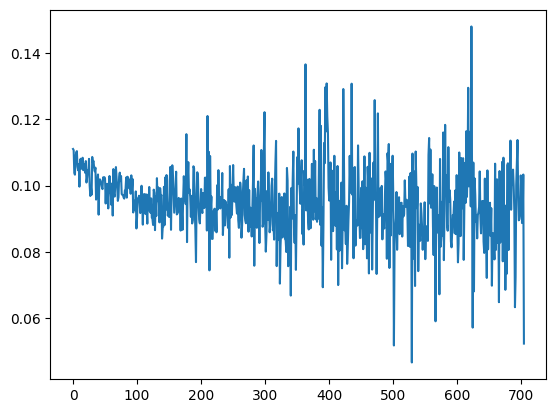

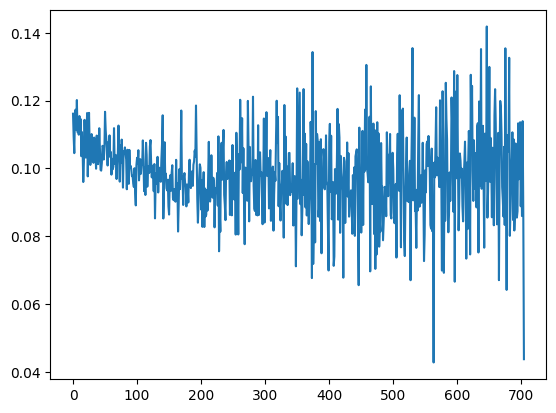

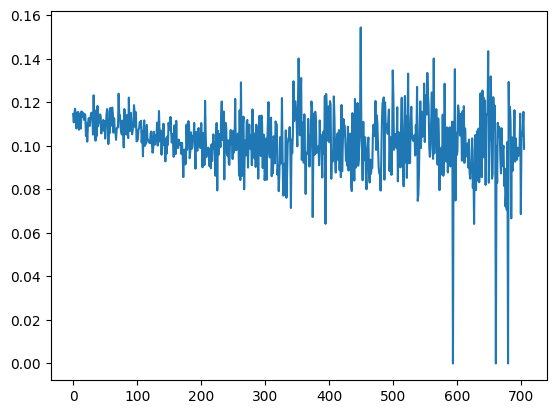

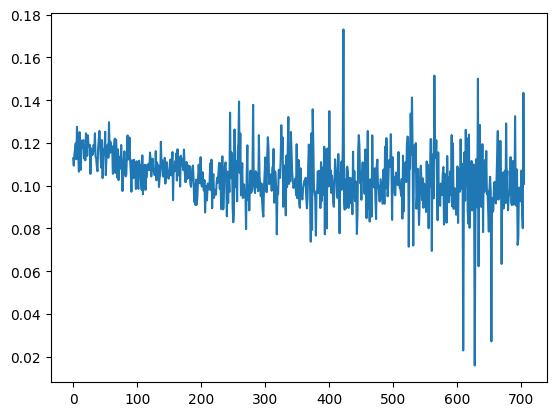

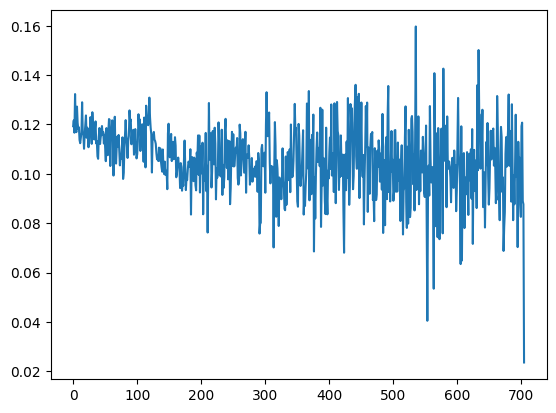

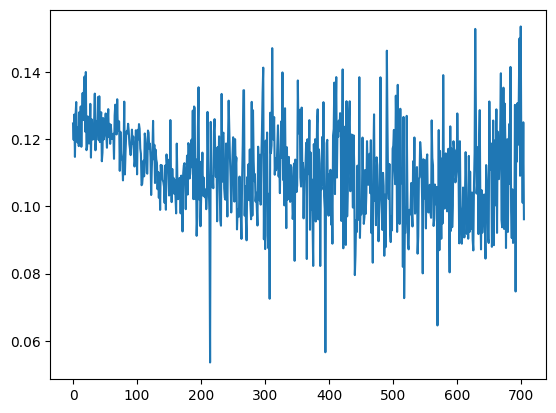

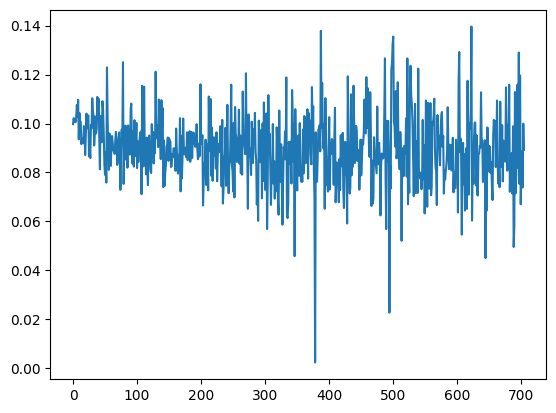

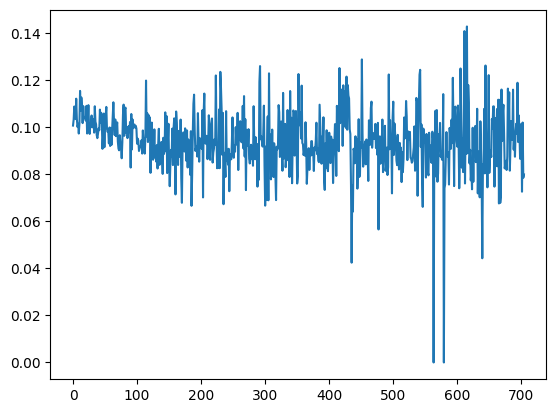

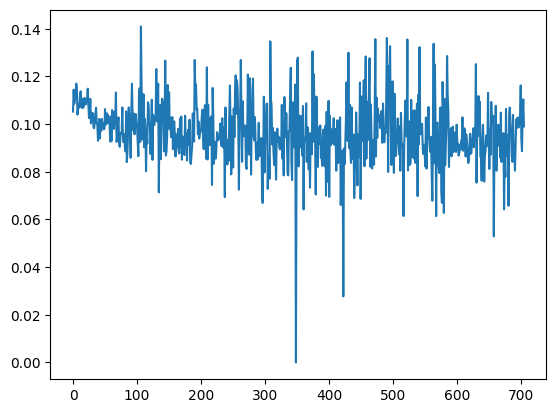

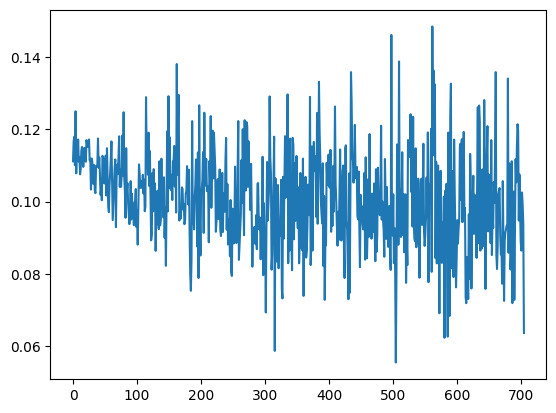

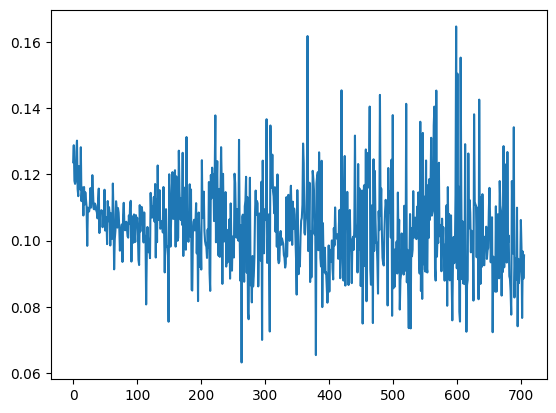

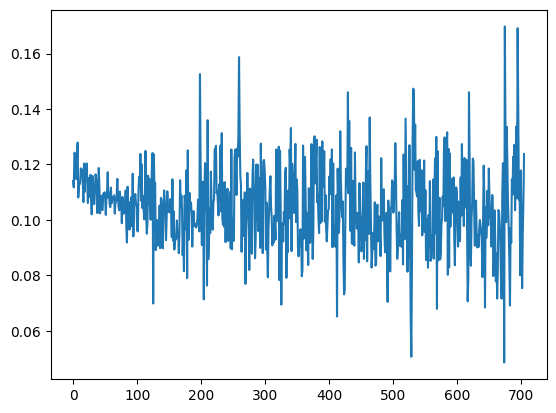

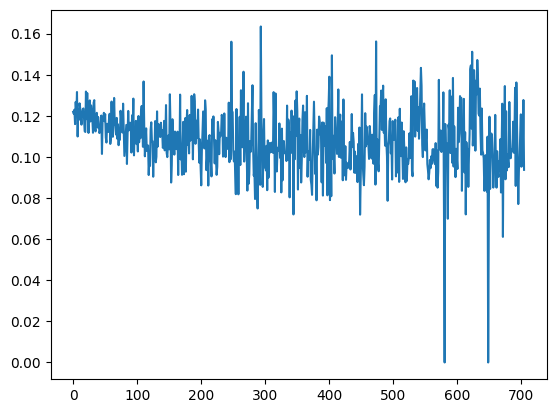

In [ ]:
average_losses = []
for lr in lrs:
    optimizer = optim.Adam(encoder.parameters(), lr=lr) 
    for m in margins:
        encoder.load_state_dict(torch.load('weights/original_weights.pth', weights_only=True))
        loss_func = model_functions.triplet_loss(margin = m)
        
        encoder.train()
        losses = model_functions.train_model(encoder, train_data = train_dataloader, 
                                            num_epochs=num_epochs, 
                                            loss_func=loss_func, 
                                            optimizer=optimizer, 
                                            path = "weights/varying_margin/",
                                            name = f"model_with_margin_{m}_and_lr_{lr}.pth")

        encoder.eval()

        fig_losses, ax_losses = plt.subplots()
        ax_losses.plot(list(range(len(losses))), losses)

        losses.append(sum(losses) / len(losses))

    

In [7]:
for lr in lrs:
    for m in margins:
        model_name = f"model_with_margin_{m}_and_lr_{lr}.pth"
        encoder.load_state_dict(torch.load(f'weights/varying_margin/{model_name}', weights_only=True))
        
        collection_name = f"embeddings_from_margin_{m}_and_lr_{lr}"

        dataloading.save_full_embeddings(encoder, val_dataloader, collection_name)
        
        raw_embeddings, raw_labels, _, _ = datalaoding.load_full_embeddings(val, collection_name)
        embeddings, labels = model_functions.reduce_pca(raw_embeddings, raw_labels)
        
        title = f"Results with triplet loss margin of {m} and learning rate of {lr}"
        svm = data_vis.plot_with_decision_boundary('rbf', embeddings, labels, title = title)

NameError: name 'gc' is not defined